In [8]:
import json
from scipy.stats import kendalltau, spearmanr
import rbo
import pandas as pd
import numpy as np

import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

# set column width to be able to see full text
pd.set_option('display.max_colwidth', 100)

base_path = f'../top_k_rankings'

In [9]:
with open(f'{base_path}/project-151-at-2024-02-07-14-54-bdd3deda.json', 'r') as f:
    annotations = json.load(f)
annotations[0]["annotations"][0]["result"][0]["value"]["ranker"]["rank"]

['chatgpt_22_multimedqa_6',
 'meta-llama_Llama-2-13b-chat-hf_22_multimedqa_10',
 'gpt2-xl_22_multimedqa_10',
 '01f617ac-9919-44fe-8fc8-2db9ff72b5e7',
 'gpt2_22_multimedqa_9']

In [10]:
len(annotations)

20

In [11]:
rankings = {}
for annotation in annotations:
    annotated_rankings = list(zip(range(len(annotation["annotations"][0]["result"][0])),
                                  annotation["annotations"][0]["result"][0]["value"]["ranker"]["rank"]))
    system_rankings = [(x["score"], x["id"]) for x in annotation["data"]["items"]]
    rankings[annotation["id"]] = {"annotated_rankings": annotated_rankings, "system_rankings": system_rankings}

In [13]:
d = {}
for k, v in rankings.items():
    a = [x[1] for x in v["annotated_rankings"]]
    s = [x[1] for x in sorted(v["system_rankings"], key=lambda x: x[0], reverse=True)]
    a0 = np.array([x[0] for x in v["annotated_rankings"]])
    s0 = np.array([dict(zip(a,a0))[x] for x in s])
    d[k] = {"rbo": rbo.RankingSimilarity(a0, s0).rbo(p=1),
            "kendall": kendalltau(a0,s0).correlation,
            "spearman": spearmanr(a0, s0).correlation}
    print(k, rbo.RankingSimilarity(a0, s0).rbo(), kendalltau(a0, s0).correlation, spearmanr(a0, s0).correlation)

122997 0.7333333333333333 0.6 0.7999999999999999
122998 1.0 0.9999999999999999 0.9999999999999999
122999 0.95 0.7999999999999999 0.8999999999999998
123000 0.9333333333333332 0.7999999999999999 0.8999999999999998
123001 1.0 0.9999999999999999 0.9999999999999999
123002 0.7333333333333333 0.6 0.7999999999999999
123003 0.9333333333333332 0.7999999999999999 0.8999999999999998
123004 0.8333333333333333 0.39999999999999997 0.6
123005 0.7333333333333333 0.6 0.7999999999999999
123006 0.9333333333333332 0.7999999999999999 0.8999999999999998
123007 0.6833333333333333 0.39999999999999997 0.6
123008 0.8333333333333333 0.6 0.7
123009 0.6833333333333333 0.19999999999999998 0.49999999999999994
123010 0.5333333333333333 -0.19999999999999998 0.0
123011 0.6833333333333333 0.39999999999999997 0.6
123012 0.8833333333333332 0.6 0.7
123013 0.9333333333333332 0.7999999999999999 0.8999999999999998
123014 0.9333333333333332 0.7999999999999999 0.8999999999999998
123015 1.0 0.9999999999999999 0.9999999999999999
1

In [14]:
pd.DataFrame(d).T.describe()

,rbo,kendall,spearman
count,20.000000,20.000000,20.000000
mean,0.837500,0.640000,0.770000
std,0.133320,0.294511,0.234184
min,0.533333,-0.200000,0.000000
25%,0.733333,0.550000,0.675000
50%,0.858333,0.700000,0.850000
75%,0.933333,0.800000,0.900000
max,1.000000,1.000000,1.000000


In [15]:
rankings

{122997: {'annotated_rankings': [(0, 'chatgpt_22_multimedqa_6'),
   (1, 'meta-llama_Llama-2-13b-chat-hf_22_multimedqa_10'),
   (2, 'gpt2-xl_22_multimedqa_10'),
   (3, '01f617ac-9919-44fe-8fc8-2db9ff72b5e7'),
   (4, 'gpt2_22_multimedqa_9')],
  'system_rankings': [(-0.0107910428196191,
    'meta-llama_Llama-2-13b-chat-hf_22_multimedqa_10'),
   (-5.417914390563965, 'gpt2_22_multimedqa_9'),
   (-0.0249859765172004, '01f617ac-9919-44fe-8fc8-2db9ff72b5e7'),
   (-0.0136555787175893, 'chatgpt_22_multimedqa_6'),
   (-0.0948760733008384, 'gpt2-xl_22_multimedqa_10')]},
 122998: {'annotated_rankings': [(0, 'chatgpt_35_multimedqa_4'),
   (1, 'meta-llama_Llama-2-13b-chat-hf_35_multimedqa_4'),
   (2, 'gpt2-xl_35_multimedqa_3'),
   (3, '74c382e8-098c-4253-b573-a0b989cbb46c'),
   (4, 'gpt2_35_multimedqa_4')],
  'system_rankings': [(-3.247481346130371, 'gpt2_35_multimedqa_4'),
   (-0.0074790478684008, 'meta-llama_Llama-2-13b-chat-hf_35_multimedqa_4'),
   (-0.0083243306726217, 'gpt2-xl_35_multimedqa_3'),

In [16]:
annotations[0]["id"]

122997

In [10]:
# flow = dict(zip(range(5), [{}] * 5))

def Xrankings(X, nodes_dict, flows_dict):

    for i, x in enumerate(X):
        X[i] = (x.replace("document", "Document")
                .replace("chatgpt","ChatGPT")
                .replace("meta-llama","Llama-2 13B")
                .replace("gpt2-xl","GPT-2 XL")
                .replace("gpt2","GPT-2"))

    for i in range(len(X)):
        if i not in nodes_dict:
            nodes_dict[i] = {}
        if X[i] in nodes_dict[i]:
            nodes_dict[i][X[i]] += 1
        else:
            nodes_dict[i][X[i]] = 1
            
        if i < len(X) - 1:
            t = (f"{X[i]}@{i+1}", f"{X[i+1]}@{i+2}")
            if t in flows_dict:
                flows_dict[t] += 1
            else:
                flows_dict[t] = 1
                
    return nodes_dict, flows_dict
               
               
s_nodes_dict, s_flows_dict = {}, {}    
a_nodes_dict, a_flows_dict = {}, {}    
for k, v in rankings.items():
    a = [x[1].split("_")[0] if len(x[1].split("_")[0].split("-")) < 5 else "document" for x in
         sorted(v["annotated_rankings"], key=lambda x: x[0], reverse=False)]
    s = [x[1].split("_")[0] if len(x[1].split("_")[0].split("-")) < 5 else "document" for x in
         sorted(v["system_rankings"], key=lambda x: x[0], reverse=True)]


    s_nodes_dict, s_flows_dict = Xrankings(s, s_nodes_dict, s_flows_dict)
    a_nodes_dict, a_flows_dict = Xrankings(a, a_nodes_dict, a_flows_dict)
    
s_nodes = []
a_nodes = []
for k, v in s_nodes_dict.items():
    level = []
    for k2, v2 in v.items():
        level.append((f"{k2}@{k+1}", v2))
    s_nodes.append(level)
for k, v in a_nodes_dict.items():
    level = []
    for k2, v2 in v.items():
        level.append((f"{k2}@{k+1}", v2))
    a_nodes.append(level)
    
s_flows = []
a_flows = []
for k, v in s_flows_dict.items():
    s_flows.append((k[0], k[1], v))
for k, v in a_flows_dict.items():
    a_flows.append((k[0], k[1], v))

In [11]:
s_nodes

[[('Llama-2 13B@1', 7), ('ChatGPT@1', 13)],
 [('ChatGPT@2', 6), ('Llama-2 13B@2', 12), ('GPT-2 XL@2', 2)],
 [('Document@3', 8), ('GPT-2 XL@3', 11), ('Llama-2 13B@3', 1)],
 [('GPT-2 XL@4', 7), ('Document@4', 10), ('GPT-2@4', 2), ('ChatGPT@4', 1)],
 [('GPT-2@5', 18), ('Document@5', 2)]]

In [12]:
# flows = sorted(flows, key=lambda x: x[2], reverse=True)
s_flows

[('Llama-2 13B@1', 'ChatGPT@2', 6),
 ('ChatGPT@2', 'Document@3', 4),
 ('Document@3', 'GPT-2 XL@4', 7),
 ('GPT-2 XL@4', 'GPT-2@5', 7),
 ('ChatGPT@1', 'Llama-2 13B@2', 12),
 ('Llama-2 13B@2', 'GPT-2 XL@3', 9),
 ('GPT-2 XL@3', 'Document@4', 9),
 ('Document@4', 'GPT-2@5', 10),
 ('Llama-2 13B@2', 'Document@3', 3),
 ('ChatGPT@1', 'GPT-2 XL@2', 1),
 ('GPT-2 XL@2', 'Llama-2 13B@3', 1),
 ('Llama-2 13B@3', 'Document@4', 1),
 ('ChatGPT@2', 'GPT-2 XL@3', 2),
 ('GPT-2 XL@3', 'GPT-2@4', 2),
 ('GPT-2@4', 'Document@5', 2),
 ('Llama-2 13B@1', 'GPT-2 XL@2', 1),
 ('GPT-2 XL@2', 'Document@3', 1),
 ('Document@3', 'ChatGPT@4', 1),
 ('ChatGPT@4', 'GPT-2@5', 1)]

In [39]:
from sankeyflow import Sankey
import matplotlib
# boxplot of weighted_position
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

sns.set_theme(style="whitegrid")

# matplotlib.rcParams["text.usetex"] = True
# matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = "9"

colwidth_pt = 347.12354
dpi = 600

colwidth_inches = colwidth_pt / 72.27

# cmap = sns.cubehelix_palette(start=1,rot=len(s_flows+a_flows), light=.5, dark=.55, as_cmap=True)
cmap = sns.color_palette("Accent",as_cmap=True)
rgba = matplotlib.colormaps.get_cmap(cmap)
unique_flows = list(set([f"{f[0].split('@')[0]}{f[1].split('@')[0]}" for f in s_flows+a_flows]))
unique_nodes = set()
for f in s_nodes+a_nodes:
    for n in f:
        unique_nodes.add(n[0].split('@')[0])
unique_nodes = list(unique_nodes)
def colf(i):
    v = rgba(i/len(unique_flows))
    return(v[0], v[1], v[2], .5)
def coln(i):
    v = rgba(i/len(unique_nodes))
    return(v[0], v[1], v[2], .5)
flow_cols = dict([(f,colf(i)) for i, f in enumerate(unique_flows)])
node_cols = dict([(f,coln(i)) for i, f in enumerate(unique_nodes)])

In [40]:
# for i, f in enumerate(s_flows):
#     s_flows[i] = (f[0], f[1], f[2], {"color": flow_cols[f"{f[0].split('@')[0]}{f[1].split('@')[0]}"],'flow_color_mode': 'source'})
# for i, f in enumerate(a_flows):
#     a_flows[i] = (f[0], f[1], f[2], {"color": flow_cols[f"{f[0].split('@')[0]}{f[1].split('@')[0]}"],'flow_color_mode': 'source'})

In [41]:
for i, f in enumerate(s_nodes):
    for j, n in enumerate(f):
        s_nodes[i][j] = (n[0], n[1], {"color": node_cols[n[0].split('@')[0]]})
for i, f in enumerate(a_nodes):
    for j, n in enumerate(f):
        a_nodes[i][j] = (n[0], n[1], {"color": node_cols[n[0].split('@')[0]]})

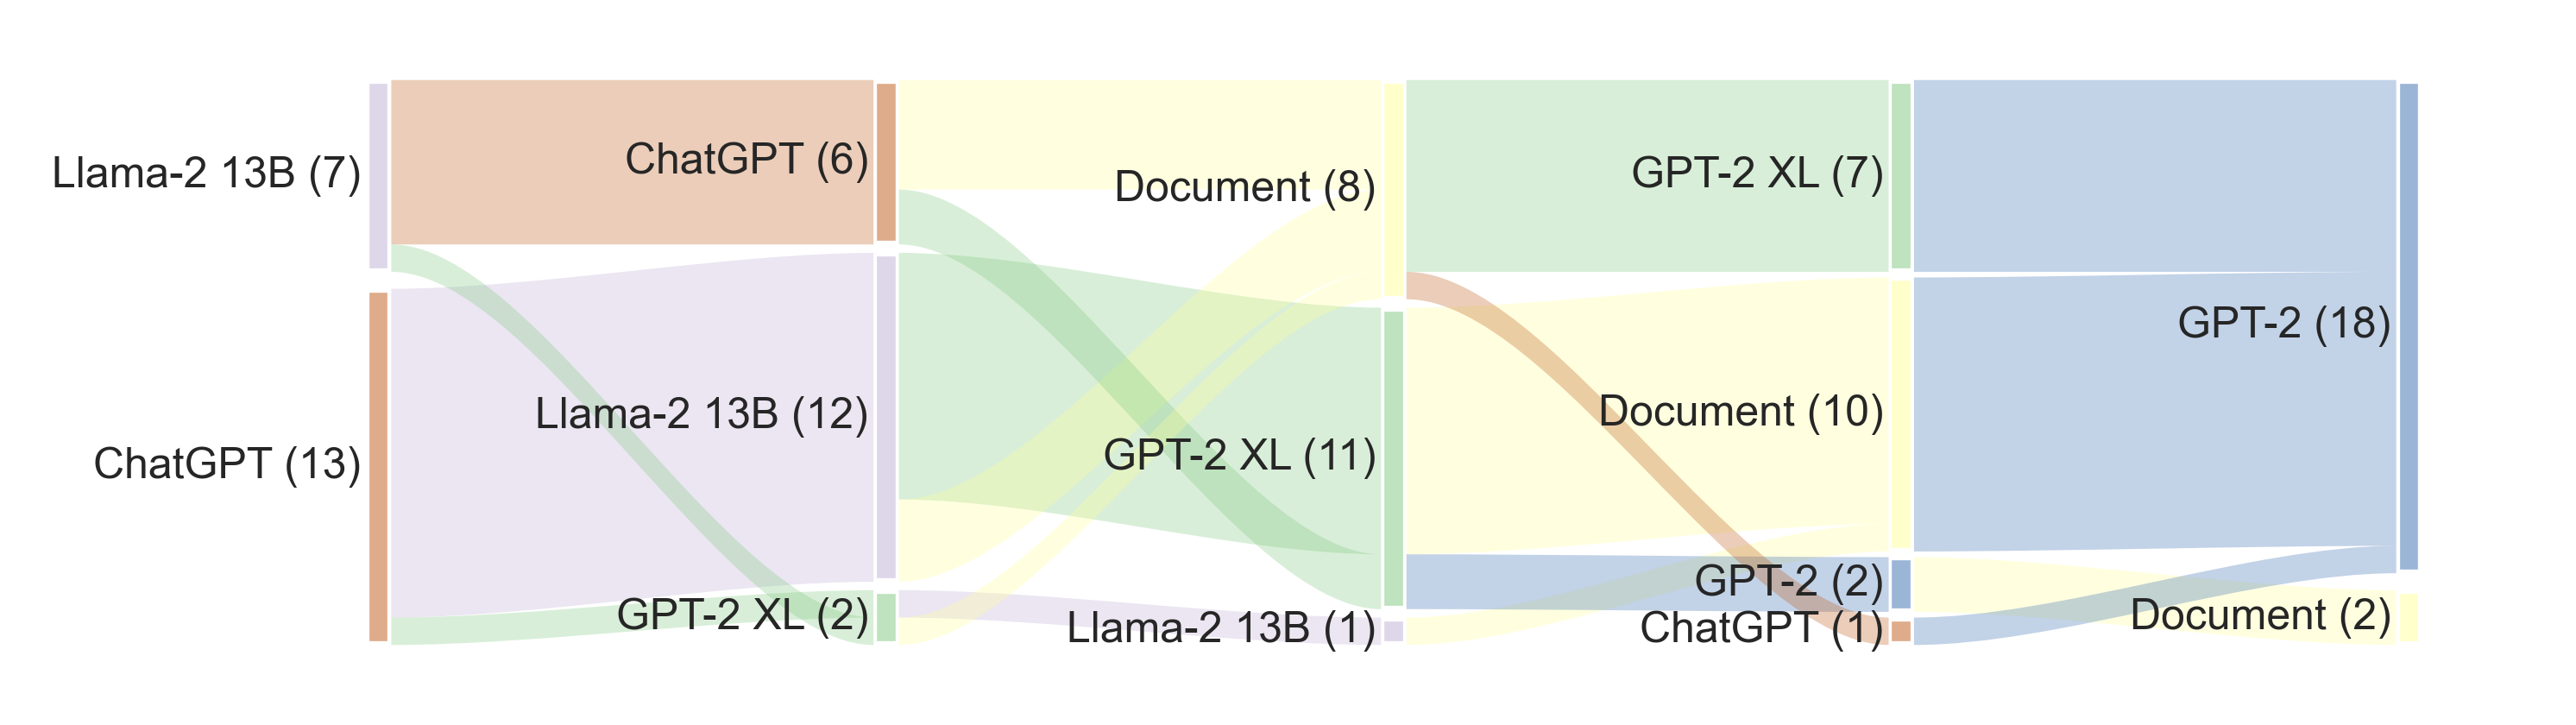

In [79]:
plt.figure(figsize=(colwidth_inches, 1.2), dpi=600)
s = Sankey(flows=s_flows, nodes=s_nodes, flow_color_mode='dest')
for n in s.nodes:
    for ni in n:
        ni.label_opts=dict(fontsize=6)
        ni.label_format = '{label} ({value})'
        ni.label = ni.label.split("@")[0]
        ni.width = 0.05
s.draw()
plt.tight_layout(pad=0)
plt.savefig("sankey-s.pdf", pad_inches=0)

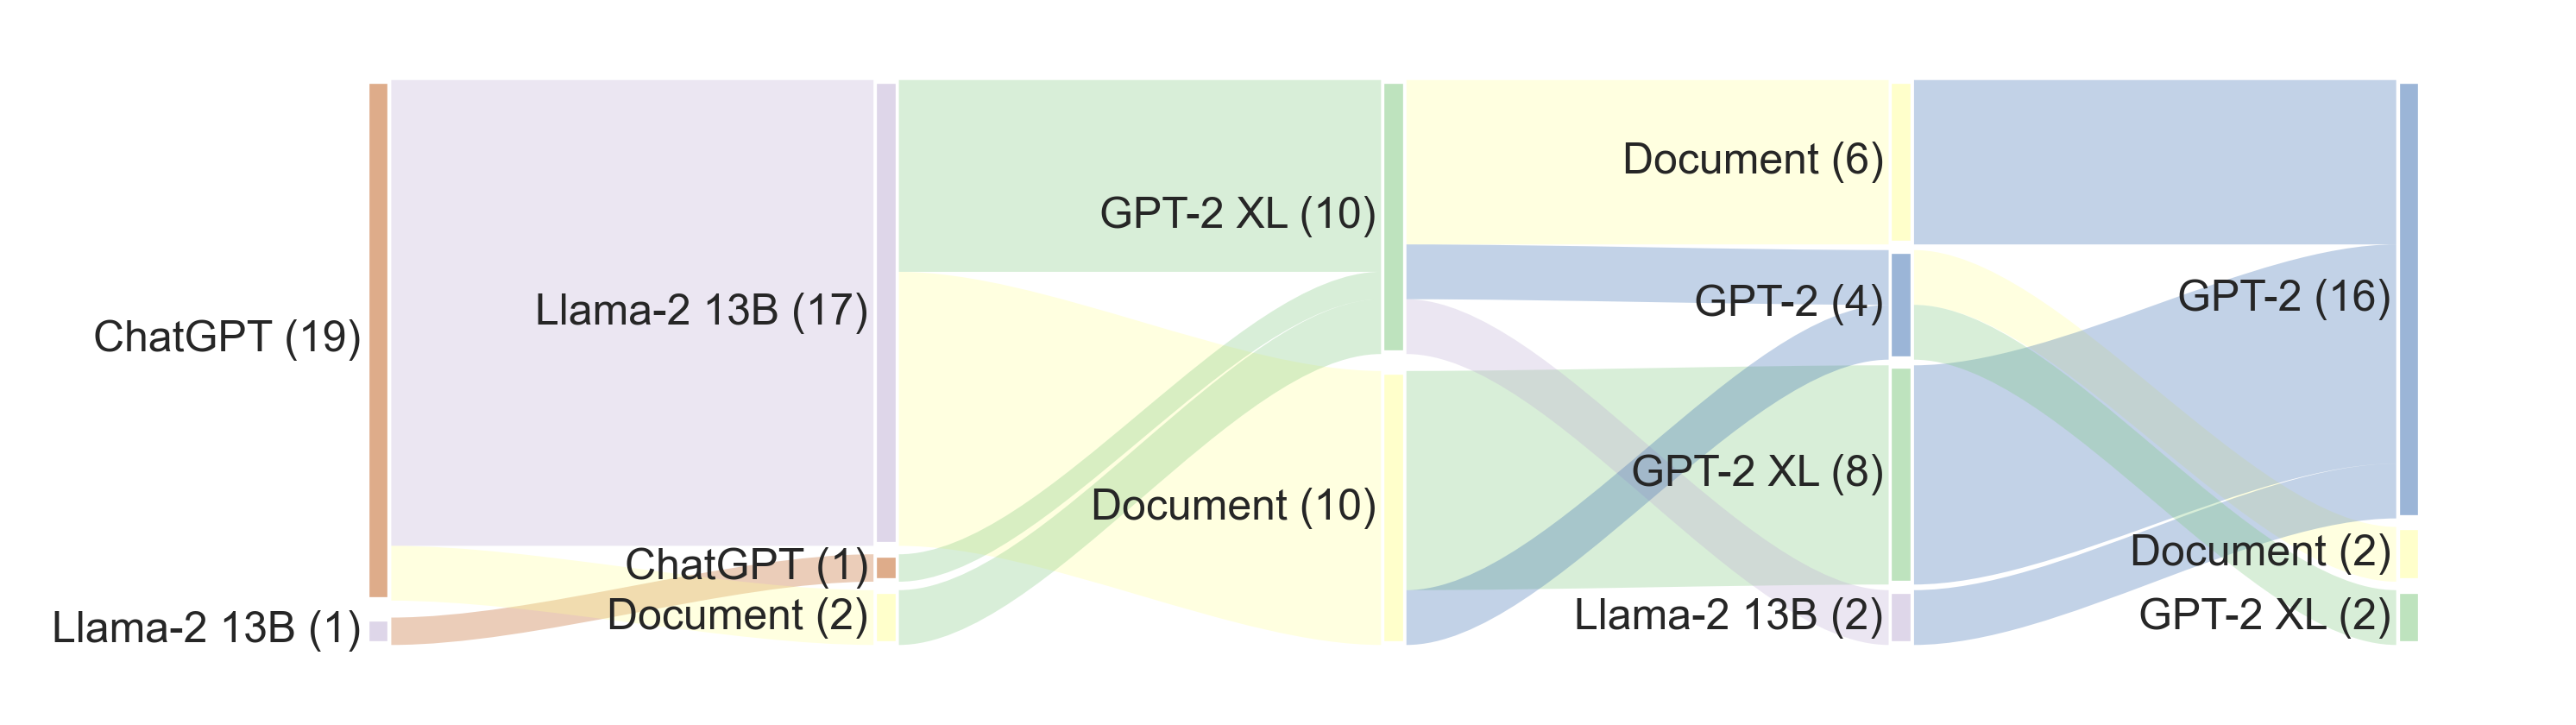

In [80]:
plt.figure(figsize=(colwidth_inches, 1.2), dpi=600)
cmap = sns.cubehelix_palette(start=1,rot=-25, light=.75, dark=.25, as_cmap=True)
s = Sankey(flows=a_flows, nodes=a_nodes, flow_color_mode='dest')
for n in s.nodes:
    for ni in n:
        ni.label_opts=dict(fontsize=6)
        ni.label_format = '{label} ({value})'
        ni.label = ni.label.split("@")[0]
        ni.width = 0.05
s.draw()
plt.tight_layout(pad=0)        
plt.savefig("sankey-a.pdf", pad_inches=0)